# Detecting SQL injections using BERT 

**Install nedded libraries**

In [ ]:
!pip install ktrain 
!pip install chardet

**Importing the libraries**

In [2]:
import numpy as np
import ktrain
from ktrain import text
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle

**Reading and displaying the dataset**

In [3]:
# Detect the encoding of the CSV file
with open('SQLiV3_3.csv', 'rb') as f:
    result = chardet.detect(f.read())
# Read the CSV file into a pandas dataframe, using the detected encoding
df = pd.read_csv('SQLiV3_3.csv', sep=',',  encoding=result['encoding'])
# Display the first rows of the dataframe
print(df.head(10))

                                            Sentence  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1   AND 1  =  utl_inaddr.get_host_address   (    ...      1
2   select * from users where id  =  '1' or @ @1 ...      1
3   select * from users where id  =  1 or 1#"  ( ...      1
4   select name from syscolumns where id   =     ...      1
5  select * from users where id  =  1 +$+ or 1  =...      1
6  1;  (  load_file  (  char  (  47,101,116,99,47...      1
7   select * from users where id  =  '1' or ||/1 ...      1
8   select * from users where id  =  '1' or \.<\ ...      1
9                                    ? or 1  =  1 --      1


In [4]:
df.shape

(22599, 2)

In [5]:
print("----------------------------------------------------")
df.info()
print("----------------------------------------------------")

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22599 entries, 0 to 22598
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  22599 non-null  object
 1   Label     22599 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 353.2+ KB
----------------------------------------------------


In [6]:
df['Label'].describe()


count    22599.000000
mean         0.499624
std          0.500011
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64

**Process NaN values**

In [7]:
df['Label'].isna().sum() # Count NaN label values.


0

**the target label**

In [8]:
# Get unique values existing in the label column.

unique_label = pd.unique(df['Label'])

print(unique_label)

[1 0]


In [9]:
df[df['Label'] == 1].count() # Count how much label are 1.


Sentence    11291
Label       11291
dtype: int64

In [10]:
df[df['Label'] == 0].count() # Count how much label are 0.


Sentence    11308
Label       11308
dtype: int64

**Distribution of the label**

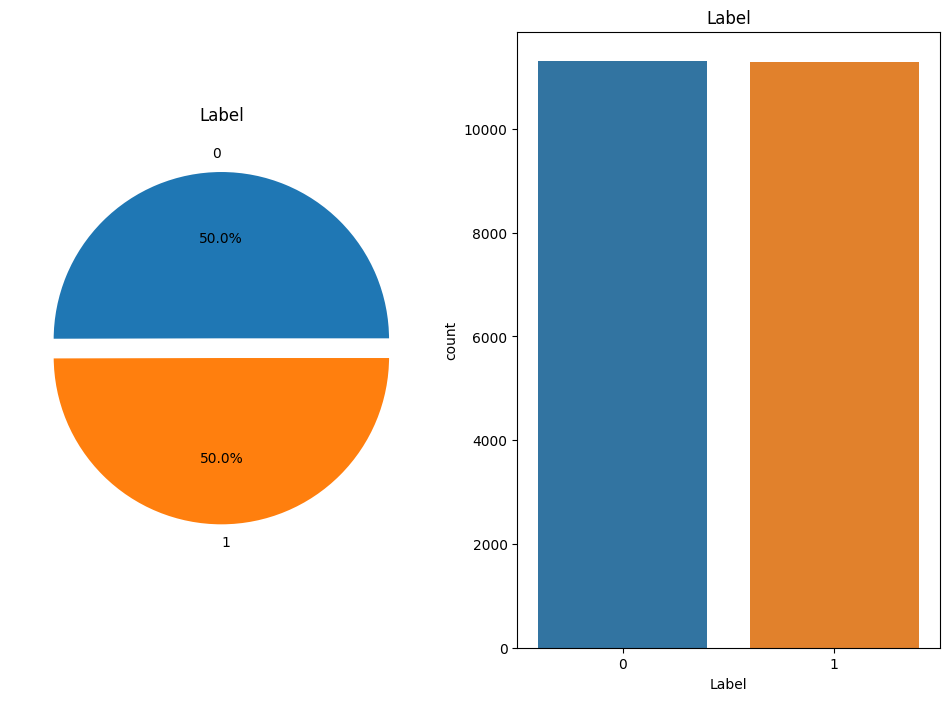

In [11]:
import matplotlib.colors as mcolors
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
df['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=df, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

**Creating the training and test sets**

In [12]:
sentences = df['Sentence'].tolist()
labels = df['Label'].tolist()
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(sentences, labels, 
                                                                       preprocess_mode='bert',
                                                                       maxlen=500,
                                                                      val_pct=0.2,
                                                                      class_names=list(set(labels))
                                                                      )

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


# Building the BERT model

In [13]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 500


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


# Training the BERT model

In [14]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [15]:
learner.fit_onecycle(lr=2e-5, epochs=4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
3014/3014 [==============================] - 2744s 897ms/step - loss: 0.0221 - accuracy: 0.9944 - val_loss: 0.0031 - val_accuracy: 0.9996
Epoch 2/4
3014/3014 [==============================] - 2703s 897ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0218 - val_accuracy: 0.9967
Epoch 3/4
3014/3014 [==============================] - 2702s 897ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0043 - val_accuracy: 0.9989
Epoch 4/4
3014/3014 [==============================] - 2645s 878ms/step - loss: 5.1445e-04 - accuracy: 0.9999 - val_loss: 4.0619e-04 - val_accuracy: 0.9998


In [16]:
learner.validate(class_names=preproc.get_classes())


142/142 [==============================] - 205s 1s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2284
           1       1.00      1.00      1.00      2236

    accuracy                           1.00      4520
   macro avg       1.00      1.00      1.00      4520
weighted avg       1.00      1.00      1.00      4520



array([[2284,    0],
       [   1, 2235]])

In [17]:
learner.view_top_losses(n=30, preproc=preproc)

142/142 [==============================] - 200s 1s/step
----------
id:3570 | loss:1.58 | true:1 | pred:0)

[CLS] select [SEP]


In [18]:
predictor = ktrain.get_predictor(learner.model, preproc)

# make predictions 
samples = [
    "SELECT cause,may,yesterday,cookies,fill     (  (  upper JOIN common ON tide.facing =  brain.object )   INNER JOIN blowON Orders.notice =  inch.sangID )",
    "UPDATE bank SET attached =  'thrown', City =  'cut' WHERE using =  origin",
    "SELECT * FROM parent WHERE NOT could = 'nation'  AND NOT prevent = 'thank'",
    "SELECT COUNT ( improve )  FROM control",
    "-2291   )    )    or 4067  =  5666#",
    "insert",
    "select",
    "update",
    "delete",
     "1'; DROP TABLE users;--",
     "UPDATE customers SET phone_number = '555-555-5555' WHERE name = 'John Doe'",
     "SELECT COUNT(*) FROM users WHERE username = 'admin' OR 1 = 1",
     "UPDATE users SET password = 'newpassword' WHERE username = 'admin'" ,
     "select * from generate_series  (  5980,5980,case when   (  5980  =  5063  )   then 1 else 0 end  )   limit 1--",
     "SELECT TOP 3 * FROM growth SELECT * FROM catch 3SELECT * FROM mainly",
     "select * from users where id  =  1 or 1#",
     "INSERT INTO column ( white, does, certain, curious, first, our )  VALUES  ( 'rose', 'anyone'. close', 'remove', 'force', 'feet', 'fell' )",
     "SELECT * FROM users WHERE username = '' OR 1=1 --' AND password = 'input_password'"]
prediction = predictor.predict(samples)
print(prediction)

[0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]


# test the Model on a new data set

In [47]:
with open('sqli.csv', 'rb') as f:
    result = chardet.detect(f.read())
# Read the CSV file into a pandas dataframe, using the detected encoding
dataset = pd.read_csv('sqli.csv', sep=',',  encoding=result['encoding'],nrows=1100)


# Separate queries and labels
queries = dataset['Sentence'].tolist()
labels = dataset['Label'].tolist()

In [56]:
correct_predictions = 0
total_queries = len(queries)
for query, label in zip(queries, labels):
    if not isinstance(query, str):
        query = str(query)
    prediction = predictor.predict(query)
    if prediction == label:
        correct_predictions += 1


accuracy = correct_predictions / total_queries
print(f"Accuracy: {accuracy}")


Accuracy: 0.9972727272727273


In [57]:
print(total_queries)
print(correct_predictions)

1100
1097


# common sentences between the train data set and the test data set

In [58]:

with open('sqli.csv', 'rb') as f:
    resultt = chardet.detect(f.read())
# Load the first CSV file
df1 = pd.read_csv('sqli.csv', sep=',',  encoding=resultt['encoding'],nrows=1100)
with open('SQLiV3_3.csv', 'rb') as f:
    result = chardet.detect(f.read())
# Load the second CSV file
df2 = pd.read_csv('SQLiV3_3.csv', sep=',',  encoding=result['encoding'])

# Extract the "sentences" column from each DataFrame
sentences1 = set(df1['Sentence'].tolist())
sentences2 = set(df2['Sentence'].tolist())

# Find the common sentences
common_sentences = sentences1.intersection(sentences2)

# Calculate the percentage of common sentences in the first dataset
similarity_percentage = (len(common_sentences) / len(sentences1)) * 100

# Print the similarity percentage
print(f"Similarity Percentage: {similarity_percentage}%")


Similarity Percentage: 9.483667017913593%


In [59]:
# Count the number of common sentences
common_sentence_count = len(common_sentences)

# Print the count of common sentences
print(f"Number of Common Sentences: {common_sentence_count}")

Number of Common Sentences: 90


In [60]:
common_sentences = list(common_sentences)
for sentence in common_sentences:
    print(sentence)


 or 2 > 1
1 uni/**/on select all from where
# from wapiti
/
,s
%2A%28%7C%28mail%3D%2A%29%29
as
0x770061006900740066006F0072002000640065006C00 ...
"^"
procedure
\x27UNION SELECT
uni/**/on sel/**/ect
bfilename
a' waitfor delay '0:0:10'--
?
%2A%7C
" or true--
 or 1 --'
admin'/*
having
||6
 ( 
t'exec master..xp_cmdshell 'nslookup www.google.com'--
.s
like
 UNION SELECT
x' OR full_name LIKE '%Bob%
admin"/*
 UNION ALL SELECT
,@variable
update
1
admin' --
 --
exec sp_addlogin 'name' , 'password'
//*
or
|
distinct
replace
PRINT @@variable
 or 'text' > 't'
admin' #
0x770061006900740066006F0072002000640065006C00610079002000270030003A0030003A
PRINT
create user name identified by 'pass123'
admin" #
s
1 waitfor delay '0:0:10'--
"&"
 union select
sqlvuln
delete
asc
" or ""^"
"-"
char%4039%41%2b%40SELECT
order by
@var select @var as var into temp end --
" or ""*"
a' --
exec sp_addsrvrolemember 'name' , 'sysadmin'
0x730065006c0065006300740020004000400076006500 ...
or a  =  a
 or 2 between 1 and 3
||UT